# Setup

In [1]:
PATH_ROOT = 'data'
PATH_PARQUET = PATH_ROOT + '/project_datasets'

In [2]:
PATH_OUTPUT = 'output'

In [3]:
!pip install pyarrow

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
%matplotlib inline  

C:\Users\steph\miniconda3\envs\ada\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# 1. Loading speakers data

## Reading wikidata labels

In [5]:
df_wikidata_labels = pd.read_csv(PATH_PARQUET + '/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
df_wikidata_labels.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


## Reading speakers parquet file

In [6]:
df_speakers = pd.read_parquet(PATH_PARQUET + '/speaker_attributes.parquet')
df_speakers.set_index(keys='id', inplace=True)
df_speakers.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
id,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,George Washington,"[Q698073, Q697949]",item,[Q682443]
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Douglas Adams,None,item,None
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Paul Otlet,None,item,None
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Diego Velázquez,None,item,None


In [7]:
df_speakers_cleaned = df_speakers.dropna()
print('Total number of speakers : ', len(df_speakers))
print('Total number of speakers with filled attributes : ', len(df_speakers_cleaned))
print('{} rows dropped'.format(len(df_speakers) - len(df_speakers_cleaned)))

Total number of speakers :  9055981
Total number of speakers with filled attributes :  3
9055978 rows dropped


As we can see that dropping all speakers with undefined attributes is unrealistic to work with, since we're only left with 3 speakers with all their attributes defined to work with. We're going to have to some fine-grained filtering of undefined values column wise instead of on whole rows (all attributes).

## 2 - Merging speakers attributes qids with wikidata labels

In [8]:
attributes_columns_to_be_labeled = ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']

# Let's first explode their attributes
for col in attributes_columns_to_be_labeled:
    df_speakers = df_speakers.explode(col)
    
# Let's also explode the date of birth
df_speakers = df_speakers.explode('date_of_birth')
    
# Keep old id and 'qid' column of speakers, and reset index
df_speakers = df_speakers.reset_index()
df_speakers = df_speakers.rename({'id': 'qid'}, axis = 'columns')
df_speakers

,qid,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
0,Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Q161885,Q6581097,1395141751,None,W000178,Q82955,Q327591,None,George Washington,Q698073,item,Q682443
1,Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Q161885,Q6581097,1395141751,None,W000178,Q82955,Q327591,None,George Washington,Q697949,item,Q682443
2,Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Q161885,Q6581097,1395141751,None,W000178,Q189290,Q327591,None,George Washington,Q698073,item,Q682443
3,Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Q161885,Q6581097,1395141751,None,W000178,Q189290,Q327591,None,George Washington,Q697949,item,Q682443
4,Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Q161885,Q6581097,1395141751,None,W000178,Q131512,Q327591,None,George Washington,Q698073,item,Q682443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12050203,Q106406560,[Barker Howard],None,Q30,Q6581097,1397399351,None,None,Q82955,None,None,Barker B. Howard,None,item,None
12050204,Q106406571,[Charles Macomber],None,Q30,Q6581097,1397399471,None,None,Q82955,None,None,Charles H. Macomber,None,item,None
12050205,Q106406588,None,+1848-04-01T00:00:00Z,None,Q6581072,1397399751,None,None,None,None,None,Dina David,None,item,None
12050206,Q106406593,None,+1899-03-18T00:00:00Z,None,Q6581072,1397399799,None,None,None,None,None,Irma Dexinger,None,item,None


#### Quick stop before proceeding: determining speaker's age

Before we continue, we need to convert the date of birth to something meaningful like the speaker's age. To avoid tedious computations using *datetime* and carefully considering none values on the month and day of birth, we're only going to approximate the age by doing calculations **based only on the year of birth** (which is good enough for our purposes).

In [9]:
def get_year_of_birth(date):
    '''
    Helper function to extract the year of birth of the speaker from the format we're given.
    
    Params:
        date: the date of birth in the given format (e.g. '+1732-02-22T00:00:00Z')
    Returns:
        the year of birth
    '''
    if date:
        return int(date[1:5])
    else:
        return date
    
test_data = '+1732-02-22T00:00:00Z'
get_year_of_birth(test_data)

1732

In [10]:
# Normalize date of birth into a new column 'age' in which we'll calculate the age of the speaker
df_speakers['age'] = df_speakers.date_of_birth.apply(get_year_of_birth)
df_speakers.age.head()

0    1732.0
1    1732.0
2    1732.0
3    1732.0
4    1732.0
Name: age, dtype: float64

In [11]:
# Calculate the age by computing the difference between now and their birth dates.
now = pd.Timestamp('now')
df_speakers.age = (now.year - df_speakers.age)
df_speakers.age.head()

0    289.0
1    289.0
2    289.0
3    289.0
4    289.0
Name: age, dtype: float64

Of course ages are just indicative, we can have people like president George Washington who are over 200 years old.

#### Let's also categorize each speaker by their age group

For example, are they in their 20s, 30s or 70s.

In [12]:
def get_age_group(age):
    '''
    Return the age group based on the age as a string. For people between 10 and 100 years old
    we just keep the tens of the value (e.g. 75 -> '70s', 20 -> '20s'). 
    For people more than 100 years old we output '>100'
    For people less than 10 years old we output '<10'
    
    Params:
        age: the age
    Returns 
        the age group in string format
    '''
    if age is None or np.isnan(age):
        return age
    elif age < 10:
        return '<10'
    elif age > 100 :
        return '>100'
    else:
        return str(int(age / 10) * 10) + 's'

df_speakers['age_group'] = df_speakers.age.apply(get_age_group)
df_speakers.age_group

0           >100
1           >100
2           >100
3           >100
4           >100
            ... 
12050203     NaN
12050204     NaN
12050205    >100
12050206    >100
12050207     NaN
Name: age_group, Length: 12050208, dtype: object

In [13]:
df_speakers[df_speakers.label == 'Donald Trump'][['date_of_birth', 'age', 'age_group']]

,date_of_birth,age,age_group
3027940,+1946-06-14T00:00:00Z,75.0,70s
3027941,+1946-06-14T00:00:00Z,75.0,70s
3027942,+1946-06-14T00:00:00Z,75.0,70s
3027943,+1946-06-14T00:00:00Z,75.0,70s
3027944,+1946-06-14T00:00:00Z,75.0,70s
...,...,...,...
3028209,+1946-06-14T00:00:00Z,75.0,70s
11238096,+1945-07-31T00:00:00Z,76.0,70s
11238097,+1945-00-00T00:00:00Z,76.0,70s
11238098,+1945-07-31T00:00:00Z,76.0,70s


#### Now let's merge attributes with their wikidata labels

In [14]:
df_speakers_labeled = df_speakers.copy()

for col in attributes_columns_to_be_labeled:
    df_speakers_labeled = df_speakers_labeled.merge(df_wikidata_labels, left_on=col, right_index=True, how='left')
    df_speakers_labeled[col] = df_speakers_labeled['Label']
    df_speakers_labeled.drop(columns=['Label', 'Description'], inplace=True)

df_speakers_labeled

,qid,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,age,age_group
0,Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Great Britain,male,1395141751,NaN,W000178,politician,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church,289.0,>100
1,Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Great Britain,male,1395141751,NaN,W000178,politician,independent politician,NaN,George Washington,1788–89 United States presidential election,item,Episcopal Church,289.0,>100
2,Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Great Britain,male,1395141751,NaN,W000178,military officer,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church,289.0,>100
3,Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Great Britain,male,1395141751,NaN,W000178,military officer,independent politician,NaN,George Washington,1788–89 United States presidential election,item,Episcopal Church,289.0,>100
4,Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Great Britain,male,1395141751,NaN,W000178,farmer,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church,289.0,>100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12050203,Q106406560,[Barker Howard],None,United States of America,male,1397399351,NaN,None,politician,NaN,NaN,Barker B. Howard,NaN,item,NaN,NaN,NaN
12050204,Q106406571,[Charles Macomber],None,United States of America,male,1397399471,NaN,None,politician,NaN,NaN,Charles H. Macomber,NaN,item,NaN,NaN,NaN
12050205,Q106406588,None,+1848-04-01T00:00:00Z,NaN,female,1397399751,NaN,None,NaN,NaN,NaN,Dina David,NaN,item,NaN,173.0,>100
12050206,Q106406593,None,+1899-03-18T00:00:00Z,NaN,female,1397399799,NaN,None,NaN,NaN,NaN,Irma Dexinger,NaN,item,NaN,122.0,>100


Now we have a row per speaker for every combination of his attributes. This might be biased for speakers with a lot of attributes (e.g. several occupations, ethnic_group, etc...).

In [15]:
display(df_speakers_labeled.dtypes)
print('Length of final labeled speakers dataframe {}'.format(len(df_speakers_labeled)))

qid                    object
aliases                object
date_of_birth          object
nationality            object
gender                 object
lastrevid               int64
ethnic_group           object
US_congress_bio_ID     object
occupation             object
party                  object
academic_degree        object
label                  object
candidacy              object
type                   object
religion               object
age                   float64
age_group              object
dtype: object

Length of final labeled speakers dataframe 12050208


## 3 - Save result to disk for quick future retrieval

In [16]:
df_speakers_labeled.to_csv(PATH_OUTPUT + '/speakers_labeled.csv', index=False)

In [17]:
# Save the dtypes of the speakers labeled. This should help when reading them in csv knowing their dtypes
import pickle

speakers_labeled_dtypes = dict(df_speakers_labeled.dtypes)

with open('output/speakers_labeled_dtypes.pickle', 'wb') as handle:
    pickle.dump(speakers_labeled_dtypes, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('output/speakers_labeled_dtypes.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(speakers_labeled_dtypes == b)

True


## 4 - Explore the speakers data (Continue work from here)

Let's do some quick analysis on the speakers' professions. First retrieve our dataframe saved in csv.

In [18]:
retrieved_labeled_speakers = pd.read_csv(PATH_OUTPUT + '/speakers_labeled.csv', dtype=speakers_labeled_dtypes)
retrieved_labeled_speakers

,qid,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,age,age_group
0,Q23,['Washington' 'President Washington' 'G. Washi...,+1732-02-22T00:00:00Z,Great Britain,male,1395141751,NaN,W000178,politician,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church,289.0,>100
1,Q23,['Washington' 'President Washington' 'G. Washi...,+1732-02-22T00:00:00Z,Great Britain,male,1395141751,NaN,W000178,politician,independent politician,NaN,George Washington,1788–89 United States presidential election,item,Episcopal Church,289.0,>100
2,Q23,['Washington' 'President Washington' 'G. Washi...,+1732-02-22T00:00:00Z,Great Britain,male,1395141751,NaN,W000178,military officer,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church,289.0,>100
3,Q23,['Washington' 'President Washington' 'G. Washi...,+1732-02-22T00:00:00Z,Great Britain,male,1395141751,NaN,W000178,military officer,independent politician,NaN,George Washington,1788–89 United States presidential election,item,Episcopal Church,289.0,>100
4,Q23,['Washington' 'President Washington' 'G. Washi...,+1732-02-22T00:00:00Z,Great Britain,male,1395141751,NaN,W000178,farmer,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church,289.0,>100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12050203,Q106406560,['Barker Howard'],NaN,United States of America,male,1397399351,NaN,NaN,politician,NaN,NaN,Barker B. Howard,NaN,item,NaN,NaN,NaN
12050204,Q106406571,['Charles Macomber'],NaN,United States of America,male,1397399471,NaN,NaN,politician,NaN,NaN,Charles H. Macomber,NaN,item,NaN,NaN,NaN
12050205,Q106406588,NaN,+1848-04-01T00:00:00Z,NaN,female,1397399751,NaN,NaN,NaN,NaN,NaN,Dina David,NaN,item,NaN,173.0,>100
12050206,Q106406593,NaN,+1899-03-18T00:00:00Z,NaN,female,1397399799,NaN,NaN,NaN,NaN,NaN,Irma Dexinger,NaN,item,NaN,122.0,>100


In [19]:
display(retrieved_labeled_speakers.dtypes)
print('Length of final labeled speakers dataframe {}'.format(len(retrieved_labeled_speakers)))

qid                    object
aliases                object
date_of_birth          object
nationality            object
gender                 object
lastrevid               int64
ethnic_group           object
US_congress_bio_ID     object
occupation             object
party                  object
academic_degree        object
label                  object
candidacy              object
type                   object
religion               object
age                   float64
age_group              object
dtype: object

Length of final labeled speakers dataframe 12050208


### 4.1 - Speakers occupations

Now let's see the distribution of the speakers' occupations.

In [20]:
grouped_by_occupations = retrieved_labeled_speakers.groupby(by='occupation').label.agg(['count'])
grouped_by_occupations = grouped_by_occupations.sort_values(by='count', ascending=False)
grouped_by_occupations.head()

,count
occupation,
researcher,1696336
politician,756733
association football player,338235
writer,307831
actor,295847


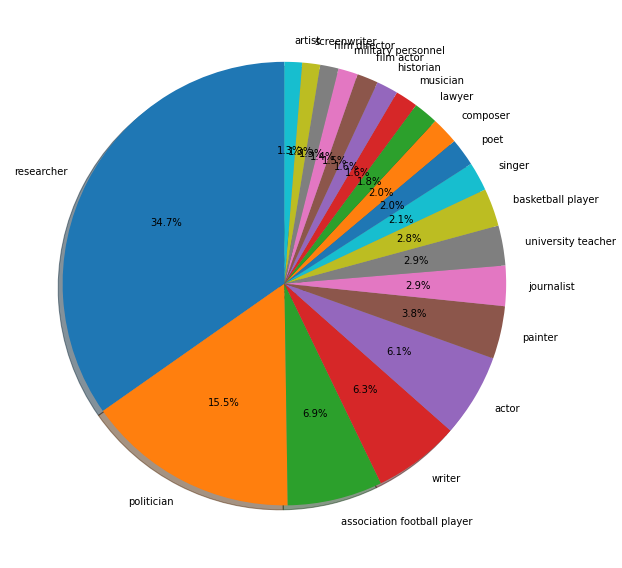

In [21]:
# Plot the distribution of the top 20 occupations
fig, ax = plt.subplots(figsize =  (14, 8))
ax.pie(grouped_by_occupations[:20]['count'], labels=grouped_by_occupations[:20].index, autopct='%1.1f%%',
        shadow=True, startangle=90)

fig.tight_layout()

Someone like Donald Trump has a lot of occupations, which means he's going to have a lot of rows dedicated to him in the dataframe, since we exploded the multi-values attributes. (This can be **problematic when training our model**)

In [22]:
# Some examples of prominent US politicans
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Donald Trump'].occupation.unique())
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Barack Obama'].occupation.unique())
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Alexandria Ocasio-Cortez'].occupation.unique())
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Hillary Clinton'].occupation.unique())
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Bill Clinton'].occupation.unique())

array(['business magnate', 'investor', 'restaurateur',
       'non-fiction writer', 'entrepreneur', 'politician',
       'businessperson', 'real estate developer', 'game show host',
       'real estate entrepreneur', 'television producer', 'film producer',
       'writer', 'actor', 'chief executive officer',
       'television presenter', 'conspiracy theorist', 'billionaire',
       'physician', 'oncologist'], dtype=object)

array(['politician', 'lawyer', 'political writer', 'community organizer',
       'statesperson'], dtype=object)

array(['politician', 'political activist', 'community organizer',
       'bartender', 'waiter', 'publisher', 'educational strategist'],
      dtype=object)

array(['politician', 'lawyer', 'diplomat', 'writer', 'autobiographer',
       'university teacher', 'podcaster'], dtype=object)

array(['politician', 'lawyer', 'diplomat', 'autobiographer', 'writer',
       'teacher', 'statesperson', 'saxophonist'], dtype=object)

### 4.2 - Speaker's gender 

In [23]:
grouped_by_gender = retrieved_labeled_speakers.groupby(by='gender').label.agg(['count'])
grouped_by_gender = grouped_by_gender.sort_values(by='count', ascending=False)
grouped_by_gender.head()

,count
gender,
male,7426793
female,2182573
transgender female,2150
non-binary,888
transgender male,494


In [24]:
not_male_mask = grouped_by_gender.index != 'male' 
not_female_mask = grouped_by_gender.index != 'female'
len(grouped_by_gender[not_male_mask & not_female_mask]) / len(grouped_by_gender)

0.9459459459459459

The majority of speakers in the Quotebank are male (almost 70%). All other genders consitute about 5% of the speakers.

### 4.3 - Speaker's age

So far we've had the speakers date of birth. Let's convert that to age.

In [25]:
# TODO
#sns.histplot(retrieved_labeled_speakers.age.dropna(axis='columns'))

## 5 - Constructing a feature matrix

If we're trying to train a model using our speakers attributes, we're going to have to think of a way to construct a feature matrix. The issue is a lot of the attributes of the speakers are categorical. One way to construct features from those is to one-hot encode them.